In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from base.api.market_data.classes.dataframe import EnhancedDataframe

In [9]:
spx = EnhancedDataframe.populate_dataframe(yf.download("^GSPC", period='3y', interval='1d'), "SPX")
for col in spx.columns:
    print("Column: ", col)

[*********************100%***********************]  1 of 1 completed
window:  20
Column:  Open
Column:  High
Column:  Low
Column:  Close
Column:  Adj_Close
Column:  Volume
Column:  Ticker
Column:  MA20
Column:  MA50
Column:  MA100
Column:  RSI
Column:  MACD_histogram
Column:  BB_lower
Column:  BB_middle
Column:  BB_upper
Column:  STOCH_K
Column:  STOCH_D
Column:  Volume_Change
Column:  Change
Column:  tenkan_sen
Column:  kijun_sen
Column:  senkou_span_a
Column:  senkou_span_b


In [10]:
columns = ("Open", "HIgh", "Low", "Close", "Volume", "RSI", 'STOCH_K', "BB_lower", "BB_middle", "BB_upper", "MACD_histogram", "MA20", "MA50")
spx = spx.drop([col for col in spx.columns if not col in columns], axis=1)

In [5]:
spx

,Open,Low,Close,Volume,MA20,MA50,RSI,MACD_histogram,BB_lower,STOCH_K
Date,,,,,,,,,,
2020-01-02,3244.669922,3235.530029,3257.850098,3458250000,3188.125989,3125.233394,75.587364,2.246944,3121.816880,99.757838
2020-01-03,3226.360107,3222.340088,3234.850098,3461290000,3194.230493,3130.010596,65.839002,0.779038,3131.682338,77.083714
2020-01-06,3217.550049,3214.639893,3246.280029,3674070000,3200.672998,3134.845796,68.044604,0.237002,3142.808844,84.082859
2020-01-07,3241.860107,3232.429932,3237.179932,3420380000,3205.236499,3139.383594,64.475350,-1.006564,3149.574204,68.767689
2020-01-08,3238.590088,3236.669922,3253.050049,3720890000,3211.091003,3143.993594,67.661207,-1.029314,3157.694160,81.535642
...,...,...,...,...,...,...,...,...,...,...
2022-08-04,4154.850098,4135.419922,4151.939941,3565810000,3967.354968,3937.956802,65.283327,25.793682,3787.180188,95.496031
2022-08-05,4115.870117,4107.310059,4145.189941,3540260000,3979.645471,3942.031001,64.481135,22.578020,3792.010514,92.679047
2022-08-08,4155.930176,4128.970215,4140.060059,3604650000,3993.926978,3945.257603,63.839112,18.636394,3802.093080,83.123084


In [6]:
def spx_entry_point(rsi, macd, bb_lower, stoch, close):
    if rsi < 30 : return True

5.47945205479452


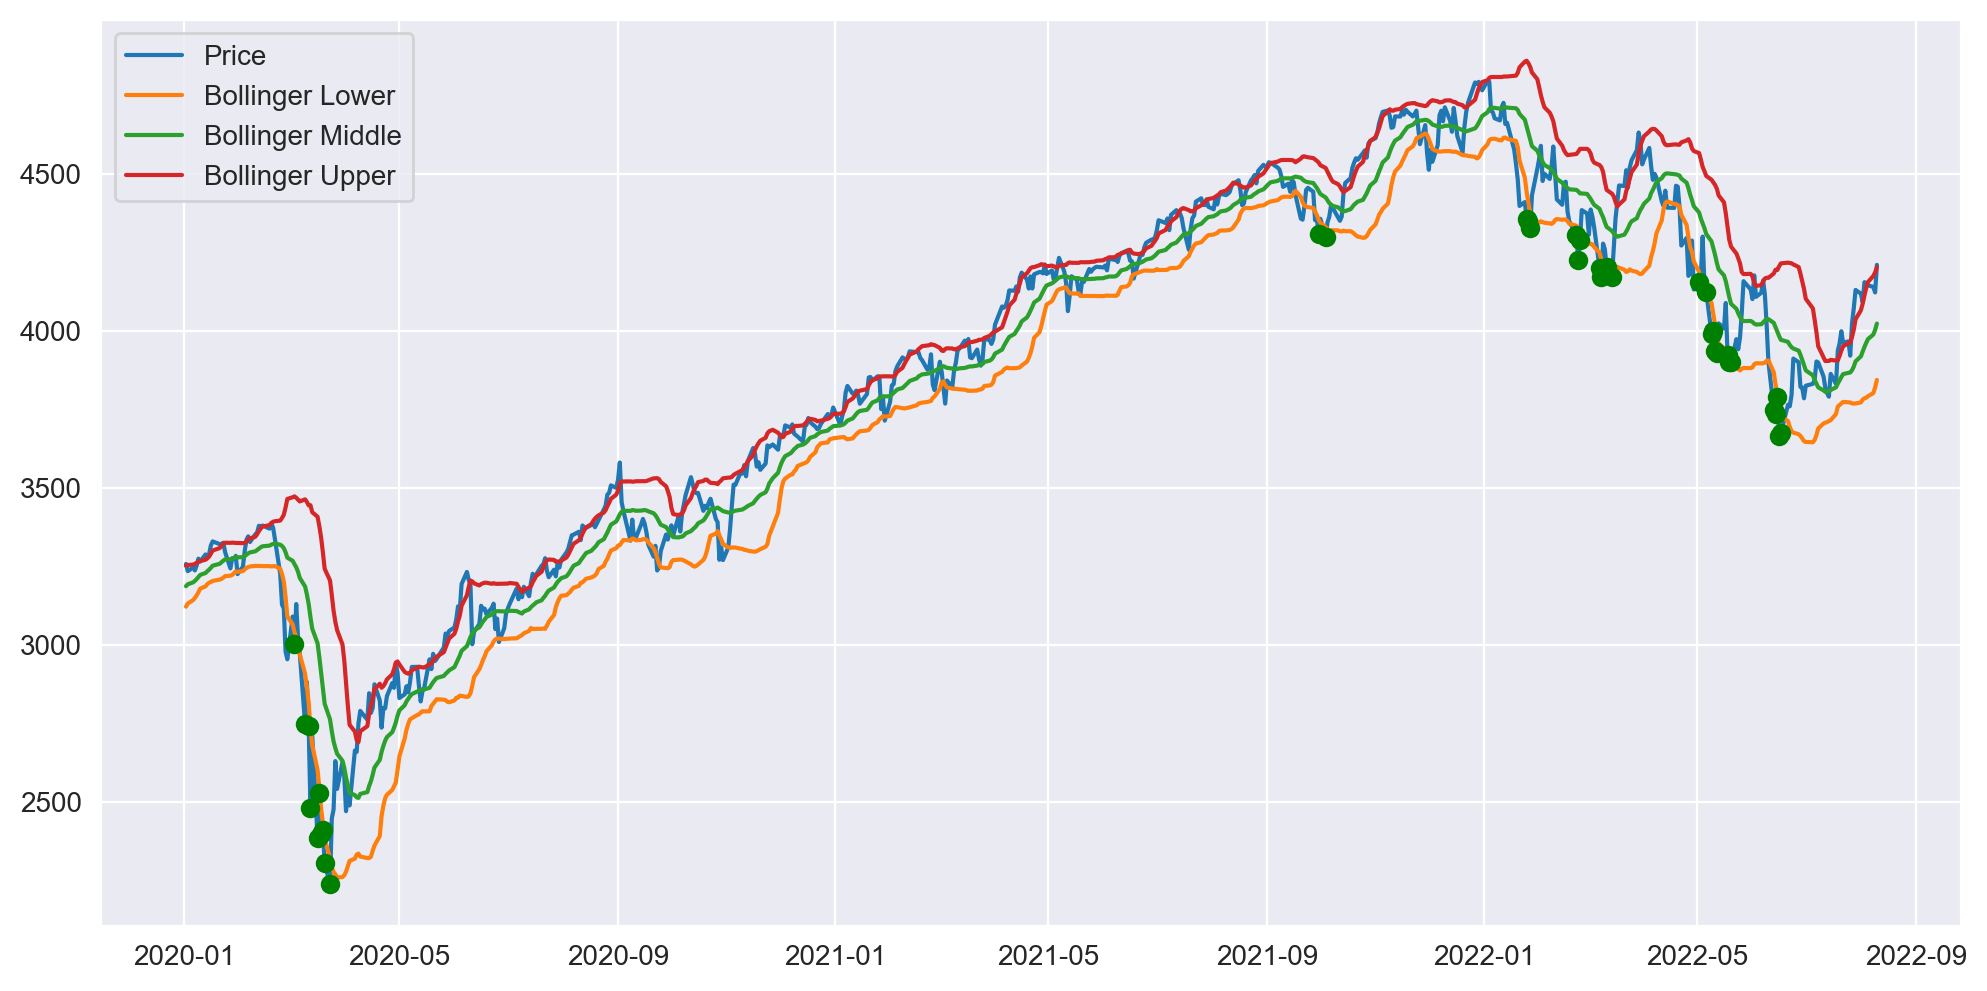

In [13]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(spx.index, spx['Close'], label='Price')
plt.plot(spx.index, spx['BB_lower'], label='Bollinger Lower')
plt.plot(spx.index, spx["BB_middle"], label='Bollinger Middle')
plt.plot(spx.index, spx['BB_upper'], label='Bollinger Upper')
entries = spx[ (spx['MACD_histogram'] < -1.5) & (spx['RSI'] < 45) & (spx['MA20'] < spx["MA50"]) & (spx['Close'] < spx['BB_lower'])]


for i, date in enumerate(entries.index):
        plt.plot(spx.loc[date].name, spx.loc[date]['Close'], marker='o', c='g')

plt.legend()

print(len(entries) / len(spx) * 100)

In [6]:
entries

,Open,Low,Close,Volume,RSI,MACD_histogram,BB_lower,STOCH_K
Date,,,,,,,,
2021-01-29,3778.050049,3694.120117,3714.239990,6612570000,43.265231,-14.049265,3727.216338,11.381320
2021-03-04,3818.530029,3723.340088,3768.469971,7142240000,40.633606,-17.391292,3827.385068,19.873140
2021-05-12,4130.549805,4056.879883,4063.040039,3735080000,41.051680,-17.296596,4127.625334,3.400392
2021-06-18,4204.779785,4164.399902,4166.450195,6084980000,43.374301,-6.185582,4179.710821,2.210314
2021-09-17,4469.740234,4427.759766,4432.990234,5622210000,43.581376,-11.796128,4446.111082,4.429210
2021-09-20,4402.950195,4305.910156,4357.729980,3773680000,33.873043,-17.349761,4426.941483,21.596998
2021-09-21,4374.450195,4347.959961,4354.189941,3044300000,33.495078,-20.279921,4409.670933,20.121612
2021-09-22,4367.430176,4367.430176,4395.640137,3273670000,41.698259,-18.494743,4399.408563,37.396850
2021-09-28,4419.540039,4346.330078,4352.629883,3495970000,38.111343,-9.946207,4380.119399,20.857976


In [68]:
accuracies = []

for i in range(2, 22 + 1):
    log_returns = []

    for date in entries.index:
        sub_df = spx[spx.index.get_loc(date) : spx.index.get_loc(date) + 16]
        log_ret = (np.exp(np.log(sub_df['Close'].iloc[-1] / sub_df['Close'].iloc[0])) -1) * 100
        log_returns.append(log_ret)

    accuracies.append(len(list(filter(lambda x: x > 0, log_returns))) / len(log_returns) * 100)

14

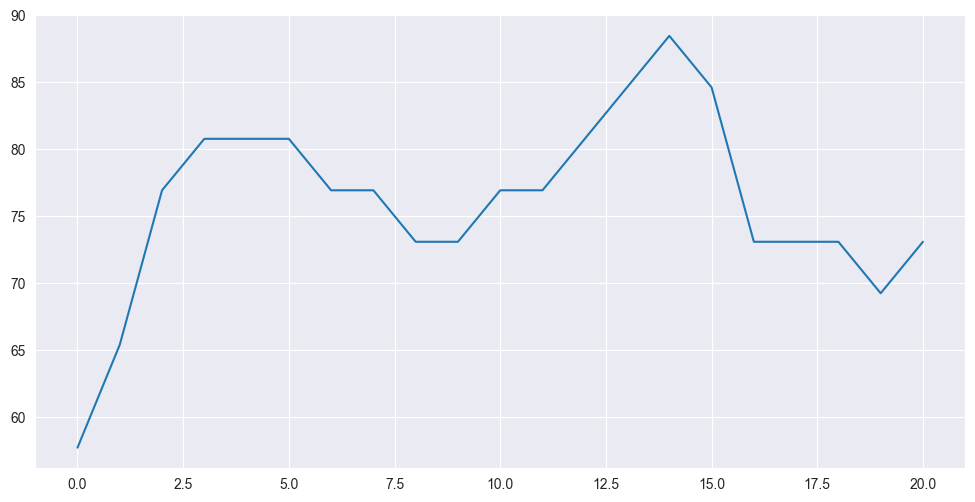

In [65]:
plt.figure(figsize=(12, 6),dpi=100)
plt.plot(range(len(accuracies)), accuracies)

# Justifies 13
accuracies.index(max(accuracies))

In [69]:
accuracy = len(list(filter(lambda x: x > 0, log_returns))) / len(log_returns) * 100
print(f"Accuracy: {accuracy:.2f}")

log_returns = np.array(log_returns)
print("Mean: ", log_returns.mean())
print("Volatility: ", log_returns.std())

Accuracy: 88.46
Mean:  3.543104405474746
Volatility:  3.6014022844213276


In [ ]:
# Results ()